In [ ]:
from google.colab import drive
drive.mount('/GD', force_remount=True)

Mounted at /GD


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("/GD/MyDrive/Colab Notebooks/Royanis/telematics_simulation_denver.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(['vin', 'timestamp'], inplace=True)

# Feature engineering
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Estimate speed (optional)
df[['lat_shift', 'lon_shift']] = df.groupby('vin')[['latitude', 'longitude']].shift(1)
df['dist_m'] = np.sqrt((df['latitude'] - df['lat_shift'])**2 + (df['longitude'] - df['lon_shift'])**2)
df.fillna({'dist_m':0}, inplace=True)

# Encode truck type
df['truck_type_code'] = df['truck_type'].astype('category').cat.codes

# Final features for unsupervised learning
features = ['latitude', 'longitude', 'hour', 'day_of_week', 'dist_m', 'truck_type_code']
df = df.dropna(subset=features)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])


In [ ]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
model.fit(x_scaled)
df['anomaly_score'] = model.decision_function(X_scaled)
df['is_predicted_anomaly'] = model.predict(X_scaled) == -1  # -1 means anomaly


In [ ]:
print(df['is_predicted_anomaly'].value_counts())

# Optional: look at a few anomalies
anomalies = df[df['is_predicted_anomaly']]
print(anomalies[['vin', 'timestamp', 'latitude', 'longitude']].head())


is_predicted_anomaly
False    9803
True      197
Name: count, dtype: int64
          vin           timestamp   latitude   longitude
37  TRUCK_001 2024-01-01 08:21:51  39.751012 -104.910338
68  TRUCK_001 2024-01-01 08:37:11  39.734687 -104.925759
88  TRUCK_001 2024-01-01 08:43:51  39.686999 -104.955060
97  TRUCK_001 2024-01-01 09:01:51  39.778927 -104.949812
98  TRUCK_001 2024-01-01 09:02:11  39.787263 -104.941707


In [ ]:
df.to_csv("/GD/MyDrive/Colab Notebooks/Royanis/telematics_with_predicted_anomalies.csv", index=False)


In [ ]:
import folium

m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=11)

for _, row in df[df['is_predicted_anomaly']].iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=row['timestamp']
    ).add_to(m)

m.save("/GD/MyDrive/Colab Notebooks/Royanis/predicted_anomalies_map.html")


In [ ]:
import folium

# Center the map on the mean coordinates
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Create separate FeatureGroups for anomalies and normal points
normal_fg = folium.FeatureGroup(name='Normal Points')
anomaly_fg = folium.FeatureGroup(name='Predicted Anomalies')

for _, row in df.iterrows():
    point = [row['latitude'], row['longitude']]
    popup_text = f"{row['vin']}<br>{row['timestamp']}"

    if row['is_predicted_anomaly']:
        folium.CircleMarker(
            location=point,
            radius=3,
            color='red',
            fill=True,
            fill_opacity=0.8,
            popup=popup_text
        ).add_to(anomaly_fg)
    else:
        folium.CircleMarker(
            location=point,
            radius=2,
            color='green',
            fill=True,
            fill_opacity=0.6,
            popup=popup_text
        ).add_to(normal_fg)

# Add layers and controls
normal_fg.add_to(m)
anomaly_fg.add_to(m)
folium.LayerControl().add_to(m)

# Save the map
m.save("/GD/MyDrive/Colab Notebooks/Royanis/map_with_anomaly_prediction.html")
print("✅ Map saved as map_with_anomaly_prediction.html")


✅ Map saved as map_with_anomaly_prediction.html


In [ ]:
print(df['is_predicted_anomaly'].mean())

0.0197


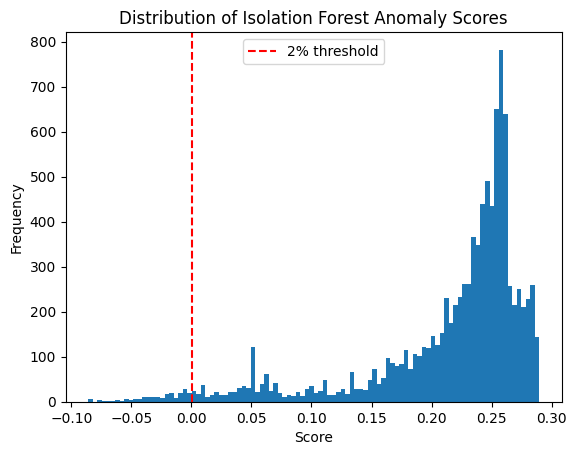

In [ ]:
import matplotlib.pyplot as plt

df['anomaly_score'] = model.decision_function(X_scaled)
plt.hist(df['anomaly_score'], bins=100)
plt.axvline(np.percentile(df['anomaly_score'], 2), color='r', linestyle='--', label='2% threshold')
plt.title("Distribution of Isolation Forest Anomaly Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

# DBSCAN - you may need to tune `eps` and `min_samples`
db = DBSCAN(eps=0.5, min_samples=10)
db.fit(X_scaled)

# -1 = anomaly
df['dbscan_label'] = db.labels_
df['dbscan_anomaly'] = (df['dbscan_label'] == -1)

# Summary
print(df['dbscan_anomaly'].value_counts())

dbscan_anomaly
False    9602
True      398
Name: count, dtype: int64


In [ ]:
import folium

m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=11)

for _, row in df[df['dbscan_anomaly']].iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=row['timestamp']
    ).add_to(m)

m.save("/GD/MyDrive/Colab Notebooks/Royanis/DBSCAN_predicted_anomalies_map_.html")

In [ ]:
import folium

# Center the map on the mean coordinates
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Create separate FeatureGroups for anomalies and normal points
normal_fg = folium.FeatureGroup(name='Normal Points')
anomaly_fg = folium.FeatureGroup(name='Predicted Anomalies')

for _, row in df.iterrows():
    point = [row['latitude'], row['longitude']]
    popup_text = f"{row['vin']}<br>{row['timestamp']}"

    if row['dbscan_anomaly']:
        folium.CircleMarker(
            location=point,
            radius=3,
            color='red',
            fill=True,
            fill_opacity=0.8,
            popup=popup_text
        ).add_to(anomaly_fg)
    else:
        folium.CircleMarker(
            location=point,
            radius=2,
            color='green',
            fill=True,
            fill_opacity=0.6,
            popup=popup_text
        ).add_to(normal_fg)

# Add layers and controls
normal_fg.add_to(m)
anomaly_fg.add_to(m)
folium.LayerControl().add_to(m)

# Save the map
m.save("/GD/MyDrive/Colab Notebooks/Royanis/DBSCAN_map_with_anomaly_prediction.html")
print("✅ Map saved as map_with_anomaly_prediction.html")


✅ Map saved as map_with_anomaly_prediction.html


In [ ]:
from sklearn.metrics import silhouette_score

mask = df['dbscan_label'] != -1  # exclude noise
score = silhouette_score(X_scaled[mask], df['dbscan_label'][mask])
print("Silhouette Score (excl. anomalies):", round(score, 4))

Silhouette Score (excl. anomalies): 0.2614


Autoencoder Model


In [ ]:
inputs_dim = x_scaled.shape[1]
encoder_large = Input(shape=(inputs_dim,))

# Encoder Layers with L2 regularization and SeLU activation

e = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(encoder_large)
e = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(e)
e = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(e)

# Bottleneck Layer
n_bottleneck = 32
bottleneck_layer = "bottleneck_layer"
bottleneck = Dense(n_bottleneck, activation="relu", name=bottleneck_layer, activity_regularizer=l2(0.0001))(e)

# Decoder Layers with L2 regularization and SeLU activation
decoder = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(bottleneck)
decoder = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(decoder)
decoder = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(decoder)



# Output Layer
output = Dense(inputs_dim, activation='linear')(decoder)  # Linear activation for the output layer

# Model Construction
model_large = Model(inputs=encoder_large, outputs=output)
model_large.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_layer (Dense)        │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,550 (95.90 KB)

 Trainable params: 24,550 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.optimizers import Adam
encoder_large = Model(inputs = model_large.input, outputs = bottleneck)

learning_rate = 1e-4
adam_optimizer = Adam(learning_rate = learning_rate)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_large.compile(optimizer=adam_optimizer, loss="mse")
history = model_large.fit(
    x_scaled,
    x_scaled,
    epochs=300,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.1139 - val_loss: 1.0857
Epoch 2/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9795 - val_loss: 0.8575
Epoch 3/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7466 - val_loss: 0.5791
Epoch 4/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5122 - val_loss: 0.3983
Epoch 5/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3711 - val_loss: 0.3337
Epoch 6/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3239 - val_loss: 0.3044
Epoch 7/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2964 - val_loss: 0.2843
Epoch 8/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2788 - val_loss: 0.2686
Epoch 9/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2639 - val_loss: 0.2554
Epoch 10/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2512 - val_loss: 0.2438
Epoch 11/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2401 - val_loss: 0.2332
Epoch 12/300
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2

In [ ]:
model_large.save("Telematics_autoencoders.h5")

In [ ]:
# Step 1: Drop invalid rows first
df = df.dropna(subset=features).reset_index(drop=True)

# Step 2: Scale after cleaning
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Step 3: Predict using autoencoder
X_pred = model_large.predict(X_scaled)

# Step 4: Compute reconstruction error
recon_error = np.mean(np.square(X_scaled - X_pred), axis=1)

# Step 5: Add to DataFrame
df['recon_error'] = recon_error


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
threshold = np.percentile(recon_error, 95)
df['ae_anomaly'] = (df['recon_error'] > threshold).astype(int)

print("Total anomalies predicted:", df['ae_anomaly'].sum())

Total anomalies predicted: 500


In [ ]:
import folium

# Initialize map
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Add markers
for _, row in df.iterrows():
    color = 'red' if row['ae_anomaly'] else 'green'
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['vin']} @ {row['timestamp']}"
    ).add_to(m)

m.save("/GD/MyDrive/Colab Notebooks/Royanis/autoencoder_anomalies_map.html")
print("✅ Map saved to autoencoder_anomalies_map.html")


✅ Map saved to autoencoder_anomalies_map.html


In [ ]:
print("Isolation Forest:", df['is_predicted_anomaly'].sum())
print("DBSCAN          :", df['dbscan_anomaly'].sum())
print("Autoencoder     :", df['ae_anomaly'].sum())


Isolation Forest: 197
DBSCAN          : 398
Autoencoder     : 500


In [ ]:
# Majority vote agreement
df['if_dbscan_agree'] = df['is_predicted_anomaly'] == df['dbscan_anomaly']
df['if_ae_agree']     = df['is_predicted_anomaly'] == df['ae_anomaly']
df['dbscan_ae_agree'] = df['dbscan_anomaly'] == df['ae_anomaly']

print("IF & DBSCAN agree:", df['if_dbscan_agree'].mean())
print("IF & AE agree     :", df['if_ae_agree'].mean())
print("DBSCAN & AE agree :", df['dbscan_ae_agree'].mean())


IF & DBSCAN agree: 0.9779
IF & AE agree     : 0.9565
DBSCAN & AE agree : 0.9454


In [ ]:
df.to_csv("/GD/MyDrive/Colab Notebooks/Royanis/telematics_data.csv", index=False)

In [ ]:
from shapely.geometry import Polygon
import geopandas as gpd

In [ ]:
from shapely.geometry import Polygon
import geopandas as gpd

# Define synthetic bounding-box zones
zone_fixed = Polygon([
    (-105.00, 39.75), (-104.95, 39.75),
    (-104.95, 39.78), (-105.00, 39.78)
])

zone_multi = Polygon([
    (-105.00, 39.74), (-104.95, 39.74),
    (-104.95, 39.79), (-105.00, 39.79)
])

zone_variable = Polygon([
    (-105.05, 39.70), (-104.90, 39.70),
    (-104.90, 39.85), (-105.05, 39.85)
])

# Create GeoDataFrame
zones = gpd.GeoDataFrame({
    "zone_id": ["Zone_Fixed", "Zone_Multi", "Zone_Variable"],
    "truck_type": ["fixed-route", "multi-route", "variable-schedule"],
    "geometry": [zone_fixed, zone_multi, zone_variable]
}, crs="EPSG:4326")

# Save to GeoJSON
zones.to_file("/GD/MyDrive/Colab Notebooks/Royanis/delivery_zones.geojson", driver="GeoJSON")

print("✅ Synthetic delivery zones saved to 'zones/delivery_zones.geojson'")


✅ Synthetic delivery zones saved to 'zones/delivery_zones.geojson'


In [ ]:
df

,vin,timestamp,latitude,longitude,truck_type,route_id,is_anomaly,deviation_type,hour,day_of_week,...,truck_type_code,anomaly_score,is_predicted_anomaly,dbscan_label,dbscan_anomaly,recon_error,ae_anomaly,if_dbscan_agree,if_ae_agree,dbscan_ae_agree
0,TRUCK_001,2024-01-01 08:00:00,39.752201,-104.903412,variable-schedule,R_TRUCK_001_1,False,none,8,0,...,2,0.133525,False,0,False,0.000736,1,True,False,False
1,TRUCK_001,2024-01-01 08:00:20,39.753751,-104.904638,variable-schedule,R_TRUCK_001_1,False,none,8,0,...,2,0.163452,False,0,False,0.000356,0,True,True,True
2,TRUCK_001,2024-01-01 08:00:40,39.756252,-104.904616,variable-schedule,R_TRUCK_001_1,False,none,8,0,...,2,0.163196,False,0,False,0.000359,0,True,True,True
3,TRUCK_001,2024-01-01 08:01:00,39.758409,-104.905054,variable-schedule,R_TRUCK_001_1,False,none,8,0,...,2,0.166059,False,0,False,0.000339,0,True,True,True
4,TRUCK_001,2024-01-01 08:01:20,39.760362,-104.905776,variable-schedule,R_TRUCK_001_1,False,none,8,0,...,2,0.167511,False,0,False,0.000317,0,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,TRUCK_100,2024-01-01 09:02:41,39.738799,-104.978744,variable-schedule,R_TRUCK_100_4,True,stop-anomaly,9,0,...,2,0.029995,False,-1,True,0.000479,0,False,True,False
9996,TRUCK_100,2024-01-01 09:03:01,39.734618,-104.978713,variable-schedule,R_TRUCK_100_4,False,none,9,0,...,2,0.029418,False,-1,True,0.000614,0,False,True,False
9997,TRUCK_100,2024-01-01 09:03:21,39.730438,-104.978717,variable-schedule,R_TRUCK_100_4,False,none,9,0,...,2,0.023708,False,-1,True,0.000799,1,False,False,True
9998,TRUCK_100,2024-01-01 09:08:41,39.725370,-105.007135,variable-schedule,R_TRUCK_100_5,False,none,9,0,...,2,-0.037701,True,-1,True,0.005305,1,True,True,True
